# Week 9 - homework: generative convolutional models

-- Prof. Dorien Herremans

Please run the whole notebook with your code and submit the `.ipynb` file on eDimension that includes your answers [so after you run it]. 

In [1]:
from termcolor import colored

student_number="1004455"
student_name="Victoria Yong"

print(colored("Homework by "  + student_name + ', number: ' + student_number,'red'))

Homework by Victoria Yong, number: 1004455


 ## Question 1 -- Generate images based on a condition

Task: develop a generative model (either cGAN or cVaE) that can generate images based on a class label (bee or ant). In other words: if I input bee, generate me an image of a bee. If I input ant, generate an image of an ant. 

a) Training dataset: small subset of ImageNet: https://download.pytorch.org/tutorial/hymenoptera_data.zip. You can leverage the ImageFolder class as demonstrated here: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html. Since we don't need a test set for generation, you can combine both test and training datasets. 

To handle using custom datasets, torchvision provides a datasets.ImageFolder class. ImageFolder expects data to be stored in the following way:

*   root/class_x/xxy.png
*   root/class_x/xxz.jpg
*   root/class_y/123.jpeg
*   root/class_y/nsdf3.png
*   root/class_y/asd932_.jpg

b) Normalize the training data and perform data augmentation. For those interested in knowing how to calculate the means for normalizing, please refer to this excellent resource here: https://github.com/bentrevett/pytorch-image-classification/blob/master/5_resnet.ipynb and the previously mentioned link. 



In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader

plt.rcParams["figure.figsize"] = (15, 60)

In [3]:
# load images and normalize + augment data
data_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

path = './data'
dataset = datasets.ImageFolder(path, data_transforms)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=2)
dataset_size = len(dataset)
class_names = dataset.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0



c) Show a few images from the dataset so we understand what we are working with. 



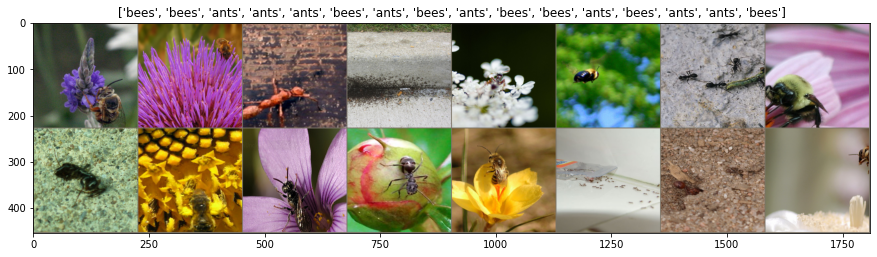

In [4]:
# explore the data
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(dataloader))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])


d) Implement a conditional generative model. Use at least one convolutional layer in your generative model and define a loss function that makes sense for this problem. 


In [5]:
# your model here
latent_dims = 50
batch_size = 8
capacity = 32
variational_beta = 1
img_size = inputs.shape[3] # 224

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        # use an embedding layer for the layer
        self.label_emb = nn.Embedding(2, img_size*img_size)
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=4, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=c*2, out_channels=c*4, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(in_channels=c*4, out_channels=c*8, kernel_size=4, stride=2, padding=1) 
        self.conv5 = nn.Conv2d(in_channels=c*8, out_channels=c*16, kernel_size=4, stride=2, padding=1) 
        self.fc_mu = nn.Linear(in_features=c*16*7*7, out_features=latent_dims)
        self.fc_logvar = nn.Linear(in_features=c*16*7*7, out_features=latent_dims) 
            
    def forward(self, x, labels):
        c = self.label_emb(labels) # (batch_size, 224*224)
        c = c.view(-1, 1, 224, 224) # (batch_size, 1, 224, 224)
        x = torch.cat([x, c], axis=1) # (batch_size, 4, 224, 224)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = x.view(x.size(0), -1) 

        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x) 
        return x_mu, x_logvar

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        # use an embedding layer for the layer
        self.label_emb = nn.Embedding(2, 1)
        c = capacity
        self.fc1 = nn.Linear(in_features=latent_dims+1, out_features=c*16*7*7)
        self.conv5 = nn.ConvTranspose2d(in_channels=c*16, out_channels=c*8, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.ConvTranspose2d(in_channels=c*8, out_channels=c*4, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.ConvTranspose2d(in_channels=c*4, out_channels=c*2, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=3, kernel_size=4, stride=2, padding=1)
            
    def forward(self, x, labels):
        c = self.label_emb(labels) # (batch_size, 1)
        x = torch.cat([x, c], axis=1) # (batch_size, latent_dims+1)
        x = self.fc1(x)
        x = x.view(x.size(0), capacity*16, 7, 7) 
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv2(x))
        x = self.conv1(x)
        return x 

class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x, labels):
        latent_mu, latent_logvar = self.encoder(x, labels)

        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent, labels)
        return x_recon, latent_mu, latent_logvar
    
    def latent_sample(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_() 
            return eps.mul(std).add_(mu)
        else:
            return mu

def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x.view(-1, 3*224*224), x.view(-1, 3*224*224), reduction='sum')
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + variational_beta * kldivergence


e) Train the network on cuda (I recommend to be clever and use a technique such as mini batches to train effectively, optional though). Show how the loss of the model evolves during training. 

f) Generate 4 images of each class after a number of epochs so we can see the generation quality improving during training. This should be done regularly during training so you can follow the process. 





In [6]:
# train the network
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img, classes):
    img = to_img(img)
    npimg = img.numpy()
    img = np.transpose(npimg, (1, 2, 0))
    plt.title(classes)
    plt.imshow(img)

num_epochs = 500
use_gpu = True
learning_rate = 1e-4
sample_size = 8

vae = VariationalAutoencoder().to(device)
print(vae)

optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5)


VariationalAutoencoder(
  (encoder): Encoder(
    (label_emb): Embedding(2, 50176)
    (conv1): Conv2d(4, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (fc_mu): Linear(in_features=25088, out_features=50, bias=True)
    (fc_logvar): Linear(in_features=25088, out_features=50, bias=True)
  )
  (decoder): Decoder(
    (label_emb): Embedding(2, 1)
    (fc1): Linear(in_features=51, out_features=25088, bias=True)
    (conv5): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), pad

Training ...
Epoch [1 / 500] average reconstruction error: 3390156.380000


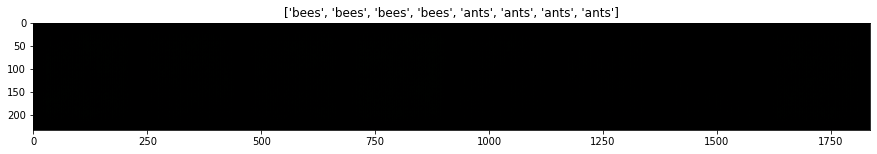

Epoch [26 / 500] average reconstruction error: 1290173.792500
Epoch [51 / 500] average reconstruction error: 1069179.000000
Epoch [76 / 500] average reconstruction error: 1005391.957500
Epoch [101 / 500] average reconstruction error: 992886.092500


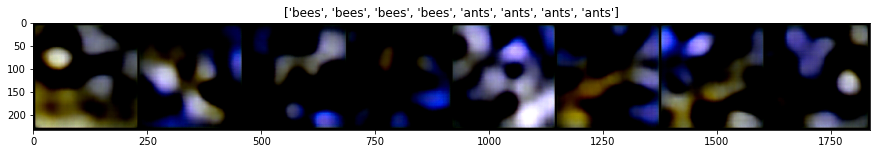

Epoch [126 / 500] average reconstruction error: 953558.380000
Epoch [151 / 500] average reconstruction error: 905328.752500
Epoch [176 / 500] average reconstruction error: 866277.180000
Epoch [201 / 500] average reconstruction error: 863340.922500


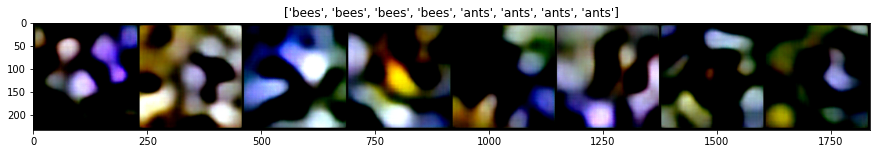

Epoch [226 / 500] average reconstruction error: 842810.985000
Epoch [251 / 500] average reconstruction error: 857966.453750
Epoch [276 / 500] average reconstruction error: 851763.732500
Epoch [301 / 500] average reconstruction error: 841513.407500


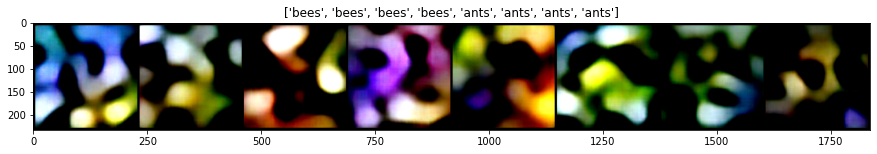

Epoch [326 / 500] average reconstruction error: 846491.012500
Epoch [351 / 500] average reconstruction error: 827703.135000
Epoch [376 / 500] average reconstruction error: 822709.455000
Epoch [401 / 500] average reconstruction error: 828850.592500


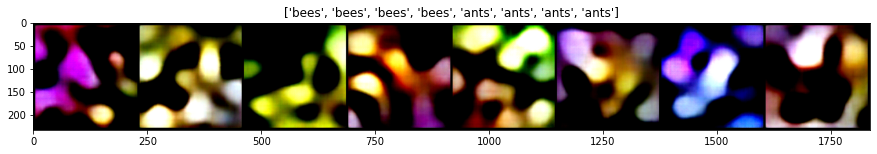

Epoch [426 / 500] average reconstruction error: 821682.057500
Epoch [451 / 500] average reconstruction error: 829940.200000
Epoch [476 / 500] average reconstruction error: 824298.990000


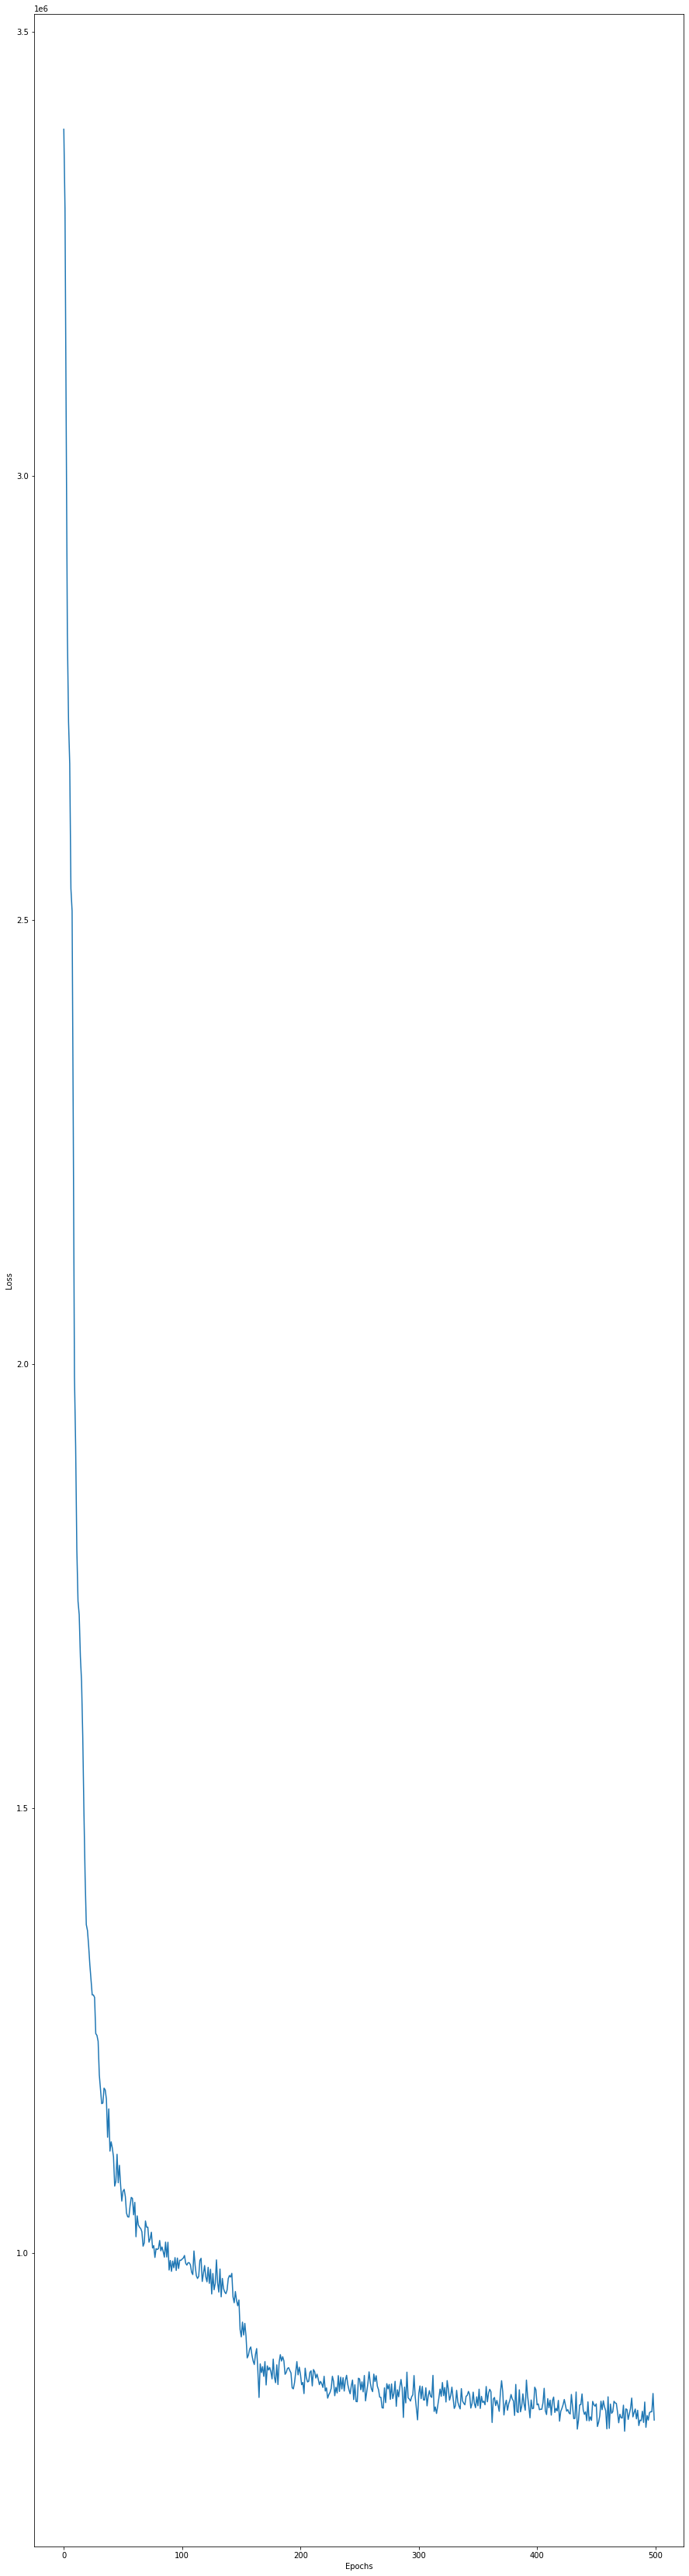

In [7]:

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    # set to training mode
    vae.train()
    train_loss_avg.append(0)  
    num_batches = 0 
    for i, (image_batch, labels) in enumerate(dataloader):        
        image_batch = image_batch.to(device)
        labels = labels.to(device)
        
        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch, labels)        
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)

        # backprop
        optimizer.zero_grad()
        loss.backward()        
        optimizer.step()        
        train_loss_avg[-1] += loss.item()    
        num_batches += 1    
    train_loss_avg[-1] /= num_batches

    if epoch % 25 == 0:
        print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

    if epoch % 100 == 0:
        vae.eval()
        with torch.no_grad():
            # sample latent vectors from the normal distribution
            latent = torch.randn(sample_size, latent_dims).to(device)
            # reconstruct images from the latent vectors
            labels = torch.LongTensor([1,1,1,1,0,0,0,0]).to(device)
            classes = [class_names[i] for i in labels]
            img_recon = vae.decoder(latent, labels)
            img_recon = img_recon.cpu()
            fig, ax = plt.subplots(figsize=(15, 15))
            show_image(torchvision.utils.make_grid(img_recon.data[:8],8,5), classes)
            plt.show()
            
# loss during training
plt.ion()
fig = plt.figure()
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

g) Showcase how your model can now take an input option and generate the appropriate image. Show this for both ants and bees. 

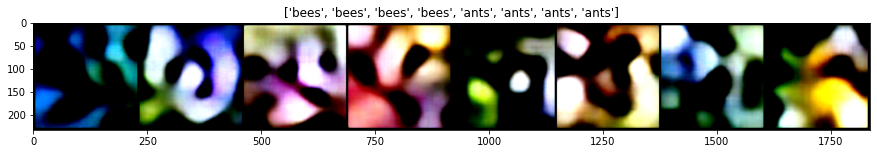

In [8]:
# predict
vae.eval()
latent = torch.randn(sample_size, latent_dims).to(device)
labels = torch.LongTensor([1,1,1,1,0,0,0,0]).to(device)
classes = [class_names[i] for i in labels] #input class names to predict
img_recon = vae.decoder(latent, labels)
img_recon = img_recon.cpu()
fig, ax = plt.subplots(figsize=(15, 15))
show_image(torchvision.utils.make_grid(img_recon.data[:8],8,5), classes)
plt.show()


h) Does this model work well enough? What might be the reason for this? Do you have any suggestions for improvement? 


##### answer
The model does not work well enough, possibly due to insufficient data (only 397 images) for the model to capture relationships that may exists between features. The lack of data could also cause some common issues with GANs to be exacerbated, such as vanishing gradients, mode collapse or failure of the discriminator to converge.

i) Is the loss function enough to assess the quality of the images? If not, how could you improve the evaluation? 

##### answer

The loss function alone is insufficient since GANs lack an objective function, which makes it difficult to compare performance of different models.
Qualitative methods can be used, which involve a level of human subjectivity. Examples of qualitative methods include Nearest Neighbors, using human participants to distinguish between real and generated images, or evaluating the model using datasets with known modes as a benchmark to evaluate the mode drop and collapse of the model. 
Quantitative methods can also be used, such as Average Log-likelihood, reconstruction error (which I used here), various image quality metrics (e.g. SSIM, sharpness etc.), F1 scores, classification scores etc.

To improve the evaluation, I would use a combination of various qualitative and quantitative methods. Such as beginning with a manual image inspection, followed by Inception Score or Frechet Inception Distance, then nearest neighbors or some human observation/preference test.